# Distribution

In [11]:
import numpy as np
from qiskit_finance.circuit.library import LogNormalDistribution
from qiskit_finance.circuit.library import NormalDistribution
# number of qubits per dimension to represent the uncertainty
num_uncertainty_qubits = 4

# parameters for considered random distribution
S = 1.0  # initial spot price
vol = 0.4  # volatility of 40%
r = 0.04  # annual interest rate of 4%
T = 80 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = (r - 0.5 * vol**2) * T + np.log(S)
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2 / 2)
variance = (np.exp(sigma**2) - 1) * np.exp(2 * mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# map to higher dimensional distribution
# for simplicity assuming dimensions are independent and identically distributed)
dimension = 2
num_qubits = [num_uncertainty_qubits] * dimension
low = low * np.ones(dimension)
high = high * np.ones(dimension)
mu = mu * np.ones(dimension)
cov = sigma**2 * np.eye(dimension) # covariance matrix

# construct circuit
u = LogNormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))
# u = NormalDistribution(num_qubits=num_qubits, mu=mu, sigma=cov, bounds=list(zip(low, high)))

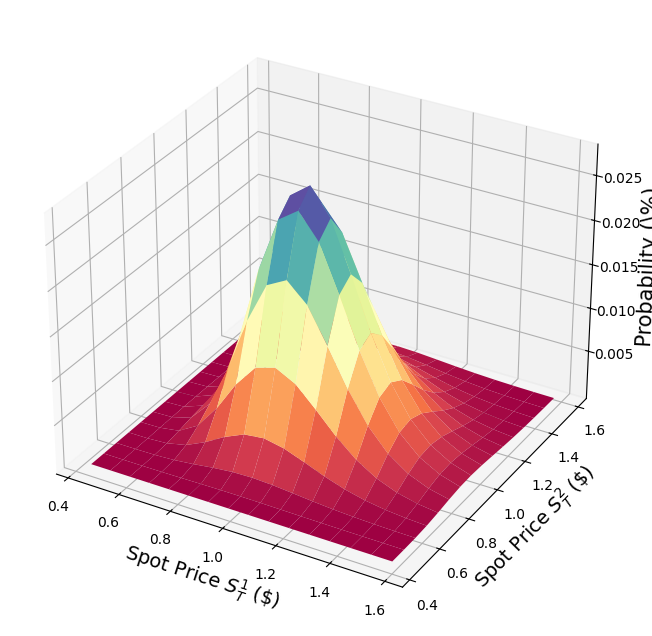

In [12]:
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

# plot PDF of uncertainty model
x = [v[0] for v in u.values]
y = [v[1] for v in u.values]
z = u.probabilities
# z = map(float, z)
# z = list(map(float, z))
resolution = np.array([2**n for n in num_qubits]) * 1j
grid_x, grid_y = np.mgrid[min(x) : max(x) : resolution[0], min(y) : max(y) : resolution[1]]
grid_z = griddata((x, y), z, (grid_x, grid_y))
plt.figure(figsize=(10, 8))
ax = plt.axes(projection="3d")
ax.plot_surface(grid_x, grid_y, grid_z, cmap=plt.cm.Spectral)
ax.set_xlabel("Spot Price $S_T^1$ (\$)", size=14)
ax.set_ylabel("Spot Price $S_T^2$ (\$)", size=14)
ax.set_zlabel("Probability (\%)", size=15)
plt.show()


In [13]:
from qiskit.circuit.library import WeightedAdder, LinearAmplitudeFunction

# determine number of qubits required to represent total loss
weights = []
for i in range(num_uncertainty_qubits):
    weights += [2**i]
    
for i in range(num_uncertainty_qubits):
    weights += [-2**i]


# we can see that weights is according to the binary representation of the number
print(weights)

[1, 2, 4, 8, -1, -2, -4, -8]


In [23]:
# create aggregation circuit
agg = WeightedAdder(sum(num_qubits), weights) # integer weights only
n_s = agg.num_sum_qubits
n_aux = agg.num_qubits - n_s - agg.num_state_qubits  # number of additional qubits
print(agg.__dict__)
print("number of sum_qubits: ", n_s)
print("number of aux_qubits: ", n_aux)

{'_base_name': 'adder', 'name': 'adder', '_data': [], '_op_start_times': None, '_control_flow_scopes': [], '_qregs': [QuantumRegister(8, 'state'), QuantumRegister(1, 'sum')], '_qubits': [Qubit(QuantumRegister(8, 'state'), 0), Qubit(QuantumRegister(8, 'state'), 1), Qubit(QuantumRegister(8, 'state'), 2), Qubit(QuantumRegister(8, 'state'), 3), Qubit(QuantumRegister(8, 'state'), 4), Qubit(QuantumRegister(8, 'state'), 5), Qubit(QuantumRegister(8, 'state'), 6), Qubit(QuantumRegister(8, 'state'), 7), Qubit(QuantumRegister(1, 'sum'), 0)], '_ancillas': [], '_qubit_indices': {Qubit(QuantumRegister(8, 'state'), 0): BitLocations(index=0, registers=[(QuantumRegister(8, 'state'), 0)]), Qubit(QuantumRegister(8, 'state'), 1): BitLocations(index=1, registers=[(QuantumRegister(8, 'state'), 1)]), Qubit(QuantumRegister(8, 'state'), 2): BitLocations(index=2, registers=[(QuantumRegister(8, 'state'), 2)]), Qubit(QuantumRegister(8, 'state'), 3): BitLocations(index=3, registers=[(QuantumRegister(8, 'state'), 3

In [17]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 0.9

# map strike price from [low, high] to {0, ..., 2^n-1}
max_value = 2**n_s - 1
print(max_value)
low_ = low[0]
high_ = high[0]
mapped_strike_price = (
    (strike_price - dimension * low_) / (high_ - low_) * (2**num_uncertainty_qubits - 1)
)
print(mapped_strike_price)

# set the approximation scaling for the payoff function
c_approx = 0.25

# setup piecewise linear objective fcuntion
breakpoints = [0, mapped_strike_price]
slopes = [0, 1]
offsets = [0, 0]
f_min = 0
f_max = 2 * (2**num_uncertainty_qubits - 1) - mapped_strike_price
basket_objective = LinearAmplitudeFunction(
    n_s,
    slopes,
    offsets,
    domain=(0, max_value),
    image=(f_min, f_max),
    rescaling_factor=c_approx,
    breakpoints=breakpoints,
)


1
0.3395905401393701


In [24]:
basket_objective.num_ancillas

1

[]


In [26]:
from qiskit import QuantumRegister, AncillaRegister, QuantumCircuit
# define overall multivariate problem
qr_state = QuantumRegister(u.num_qubits, "state")  # to load the probability distribution
qr_obj = QuantumRegister(1, "obj")  # to encode the function values
ar_sum = AncillaRegister(n_s, "sum")  # number of qubits used to encode the sum
ar = AncillaRegister(max(n_aux, basket_objective.num_ancillas), "work")  # additional qubits

objective_index = u.num_qubits

basket_option = QuantumCircuit(qr_state, qr_obj, ar_sum)
basket_option.append(u, qr_state)
basket_option.append(agg, qr_state[:] + ar_sum[:])
basket_option.append(basket_objective, ar_sum[:] + qr_obj[:] + ar[:basket_objective.num_ancillas])

print(basket_option.draw())
print("objective qubit index", objective_index)

IndexError: list index out of range